# Reporte de Actividad 1

## Eduardo Ángeles Guerrero - A01653868

Para esta actividad se diseñó un sistema multiagente de aspiradoras automáticas y basura en un cuarto de dimensiones N x M. En este sistema se realizaron una serie de experimentos para encontrar alcun comportamiento emergente de la interaccion entre nuestros agentes.
En esta actividad, nuestros agentes de aspiradoras automaticas solo tenian el precepto de su ubicación inicial p0 (1,1) y los agentes de basura tenían el precepto de su estado de limpieza, incializado en sucio (`self.dirty = True`).
A continuación se mostrara tanto la construcción del modelo de la forma descrita como los resultados de la simulación y datos estadísticos del comportamiento emergente del sistema.

Para empezar a crear el sistema importamos las siguientes librerias

In [15]:
import agentpy as ap               # Para los modelos, ambientes y agentes
import random as rand              # Para generación de numero aleatorios
import matplotlib.pyplot as plt    # Para graficar resultados estadísticos
import IPython                     # Para animar la simulación del sistema
import pandas as pd
import numpy as np

Una vez importadas las librerias se empezo con la creación de los agentes que interactuaran en el sistema.
### Clase Dirty (celdas sucias)

In [16]:
class Dirt (ap.Agent):
    def setup(self):
        self.dirty = True
        self.type = 1
        
    def clean(self):
        self.dirty = False
        self.type = 2

### Clase Vaccum (aspiradoras automáticas)

In [17]:
class Vaccum (ap.Agent):
    def setup(self):
        self.direction = (0,0)

    def turn(self, neightbors):
        for agent in neightbors:
            if (agent.dirty):
                agent.clean()
                self.direction = (0,0)
                return
        self.move()

    def move(self):
        direction = rand.randint(1,8)
        match direction:
            case 1:
                self.direction = (-1,0)
            case 2:
                self.direction = (-1,1)
            case 3:
                self.direction = (0,1)
            case 4:
                self.direction = (1,1)
            case 5:
                self.direction = (1,0)
            case 6:
                self.direction = (1,-1)
            case 7:
                self.direction = (0,-1)
            case 8:
                self.direction = (-1,-1)

## Definición del modelo
Usando `agentpy` tambien es posible crear el modelo que describe el comportamiento del sistema. Esto se hace creando una clase que sea hija de `agentpy.Model` y en la cual estableceremos la configuración inicial del sistema (preceptos de los agentes) y las acciones que cada agente tomara en una unidad de tiempo determinada.

In [18]:
class Simulation (ap.Model):
    def setup(self):
        self.map = ap.Grid(self, shape=(self.p.n, self.p.m), track_empty=True)
        self.agents = ap.AgentList(self, self.p.n_agents, Vaccum)
        self.agents.type = 0
        self.dirty_spots = ap.AgentList(self, self.p.n_dirt, Dirt)
        self.dirty_spots.type = 1
        self.map.add_agents(
            agents=self.agents, 
            positions=[(0,0)] * self.p.n_agents
        )
        self.map.add_agents(
            agents=self.dirty_spots,
            random=True,
            empty=True
        )
        # print(self.map.agents.to_list().type != 0)

    def step(self):
        for agent in self.agents:
            list = self.map.neighbors(agent, distance=0).to_list()
            list = list.select(list.type == 1)
            agent.turn(list)
        self.record(
            "Dirty Spots", 
            value=len(self.dirty_spots.select(self.dirty_spots.type == 1))
        )

    def update(self):
        for agent in self.agents:
            self.map.move_by(agent, agent.direction)
        # self.map.move_by(self.agents, self.agents.direction)
        dirty = self.dirty_spots.select(self.dirty_spots.type == 1)
        if (len(self.dirty_spots.select(self.dirty_spots.type == 1)) > 0):
            return
        self.end()

    def end(self):
        self.stop()

## Ejecución del modelo

In [19]:
def visual_simulation(model, ax):
    plot = model.map.attr_grid('type')
    ap.gridplot(
        grid=plot,
        ax=ax,
        color_dict={
            0:'#000000',
            1:'#d62c2c',
            2:'#7FC97F',
            None: '#FFFFFF'
            },
        convert=True,
    )
    ax.set_title(f"Simulation of vaccum cleaners\n"
                 f"Time-step: {model.t}, Dirty Spots Left: "
                 f"{len(model.dirty_spots.select(model.dirty_spots.type == 1))}")

n = 15
m = 15
n_agents = 10
n_dirt = 10

parameters = {
    'n':n,
    'm':m,
    'n_agents':10,
    'n_dirt':20,
    'steps': 200
}

model = Simulation(parameters)
fig, ax = plt.subplots()
animation = ap.animate(model, fig, ax, visual_simulation)
IPython.display.HTML(animation.to_jshtml(fps=10))


Scheduled runs: 5
Completed: 5, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:00:00.724999


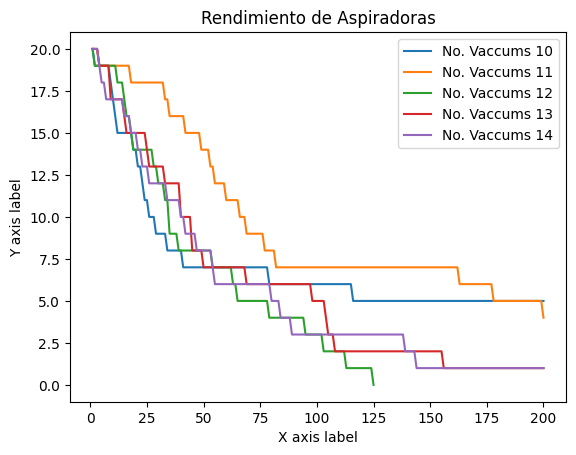

In [25]:
parameters = {
    'n':n,
    'm':m,
    'n_agents':ap.IntRange(10,15),
    'n_dirt':20,
    'steps': 200
}
sample = ap.Sample(parameters, n=5)
exp = ap.Experiment(Simulation, sample, iterations=1, record=True)
results = exp.run()
data: pd.DataFrame = results['variables']['Simulation']

for i in range(5):
    arr = data[data.index.get_level_values('sample_id') == i].to_numpy()
    list = np.vstack([a[0] for a in arr]).tolist()
    t = range(1,len(list)+1)
    plt.plot(t, list, label=f"No. Vaccums {10 + i}")

# leg = ax.legend()
plt.legend()
plt.title("Rendimiento de Aspiradoras")
plt.xlabel("X axis label")
plt.ylabel("Y axis label")
plt.show()

## Analisis
Como se puede observar en los resultados anteriores, es complicado afirmar que a mas numero de aspiradoras, menor tiempo de ejecución se necesitaria. Esto puede deberse a que los movimientos de cada una de las apiradoras se decidía de manera aleatoria.

Es posible que al agregar heuristicas de rendimiento a las aspiradoras, si se pueda lograr la hipótesis que mientras más aspiradoras se tengan, menor sería el tiempo de ejecución del sistema.